# Project: Rusty Bargain
- @author: Daniel Ramirez Guitron

#🎯 Objective:
**Rusty Bargain**: Used car sales service is developing an app to attract new customers. Thanks to this app, you can quickly find out the market value of your car. You have access to the history: technical specifications, equipment versions and prices. You have to create a model that determines the market value.
Rusty Bargain is interested in:
- the quality of the prediction;
- the speed of prediction;
- the time required for training

# 1-Data Preparartion

In [387]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import category_encoders as ce
from catboost import CatBoostRegressor


In [388]:
df = pd.read_csv('/content/raw/car_data.csv')

display(df.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99272 entries, 0 to 99271
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DateCrawled        99272 non-null  object
 1   Price              99272 non-null  int64 
 2   VehicleType        88860 non-null  object
 3   RegistrationYear   99272 non-null  int64 
 4   Gearbox            93759 non-null  object
 5   Power              99272 non-null  int64 
 6   Model              93779 non-null  object
 7   Mileage            99272 non-null  int64 
 8   RegistrationMonth  99272 non-null  int64 
 9   FuelType           90009 non-null  object
 10  Brand              99272 non-null  object
 11  NotRepaired        79347 non-null  object
 12  DateCreated        99272 non-null  object
 13  NumberOfPictures   99272 non-null  int64 
 14  PostalCode         99272 non-null  int64 
 15  LastSeen           99271 non-null  object
dtypes: int64(7), object(9)
memory usage: 12.

In [390]:
df.isna().sum()

,0
DateCrawled,0
Price,0
VehicleType,10412
RegistrationYear,0
Gearbox,5513
Power,0
Model,5493
Mileage,0
RegistrationMonth,0
FuelType,9263


In [391]:
# < Looking for binary features that can be transformed or removed >

features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'NumberOfPictures']

df[features].nunique()


,0
VehicleType,8
Gearbox,2
FuelType,7
NotRepaired,2
NumberOfPictures,1


In [392]:
print(df[features[1]].value_counts())
print(df[features[3]].value_counts())
print(df[features[4]].value_counts())

Gearbox
manual    75348
auto      18411
Name: count, dtype: int64
NotRepaired
no     69162
yes    10185
Name: count, dtype: int64
NumberOfPictures
0    99272
Name: count, dtype: int64


In [393]:
current_year = 2025

ilogic_yrs = df[df["RegistrationYear"] >= current_year ]

print(f'[+] Lenght DF: {len(ilogic_yrs)}\n')
print(ilogic_yrs.isna().sum())

[+] Lenght DF: 33

DateCrawled           0
Price                 0
VehicleType          33
RegistrationYear      0
Gearbox              26
Power                 0
Model                10
Mileage               0
RegistrationMonth     0
FuelType             24
Brand                 0
NotRepaired          29
DateCreated           0
NumberOfPictures      0
PostalCode            0
LastSeen              0
dtype: int64


### 1-0-1 Observation
🔭 **Observation**:
- **null**: We can see that all missing values ​​are categorical. so it might be a good idea to remove it if the percentage of the data amount does not corrupt the integrity of our DataFame.
- **Binary features**: `Gearbox` and `NotRepaired` candidates to binary transformation.
- **Type format**: `RegistrationYear`, `RegistrationMonth`,`LastSeen` casting to DateTime.
- **Ilogic data**: Some dates of `RegistrationYear` are above years that make sense like 19000 and also further years like 2050
- **No contribution**:
  1. `NumberOfPictures` all entries are 0, so it does not   provide any relative information.
  2. `PostalCode` don't seems to have an impact for the case.

In [394]:
# <Looking for duplications entries >
duplicated_values = df[df.duplicated()]
print(f"[+] Number of duplicated values: {duplicated_values.shape[0]}")

[+] Number of duplicated values: 26


In [396]:
# < Calculating the porpotion that null values significance to the population of our dataset >
categorical_nan_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

for category in categorical_nan_columns:
  print(f"[+] {category}: %{(df[category].isna().sum() / df.shape[0] * 100):0.2f}")


[+] VehicleType: %10.49
[+] Gearbox: %5.55
[+] Model: %5.53
[+] FuelType: %9.33
[+] NotRepaired: %20.07


# 1-1-Data Correction and Enrichment

**Correction**:
❌
- [✅] **Null** categorical values deleted.
- [✅] **Duplications** deleted.
- [✅] **Irrelevant** data colums deleted `NumberOfPictures` `PostalCode`.
- [✅] **Removing** categories before enrichment

**Enrichment**:
- [✅] **lowercase** transforamtion for columns.
- [✅] **Creating new columns**:
  - `daysactive`:
  - `yearcrawled`
  - `monthcrawled`


In [397]:
# < Creating a copy to mantain the origianl Dataset
df_copy = df.copy()

# < Removing [null] values >
df_copy = df_copy.dropna().reset_index(drop=True)

# < Removing [duplication] values  >
df_copy.drop_duplicates(inplace=True, keep='last')

# < Removing ['NumberOfPictures'] >
df_copy.drop(['NumberOfPictures'], axis=1, inplace=True)

# < Removing ['NumberOfPictures'] >
df_copy.drop(['PostalCode'], axis=1, inplace=True)


In [399]:
# < Transforming columns into lowercase format >
df_copy.columns = df_copy.columns.str.lower()

# < Casting [Date] columns to the correcto format>
df_copy["datecrawled"] = pd.to_datetime(df_copy["datecrawled"])
df_copy["datecreated"] = pd.to_datetime(df_copy["datecreated"])
df_copy["lastseen"] = pd.to_datetime(df_copy["lastseen"])

# < Creating new columns to keep the important information >
df_copy['daysactive'] = (df_copy['lastseen'] - df_copy['datecreated']).dt.days
df_copy["yearcrawled"] = df_copy["datecrawled"].dt.year
df_copy["monthcrawled"] = df_copy["datecrawled"].dt.month

# < Delete original date columns (redundant) >
df_copy.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1, inplace=True);

KeyError: 'datecrawled'

In [400]:
# < Spliting [categorical y numerical ] varibales to further EDA >
categorical_var = df_copy[df_copy.select_dtypes(include=['object']).columns]
numerical_var = df_copy[df_copy.select_dtypes(include=['int64', 'float64']).columns]

In [401]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68987 entries, 0 to 69011
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   price              68987 non-null  int64 
 1   vehicletype        68987 non-null  object
 2   registrationyear   68987 non-null  int64 
 3   gearbox            68987 non-null  object
 4   power              68987 non-null  int64 
 5   model              68987 non-null  object
 6   mileage            68987 non-null  int64 
 7   registrationmonth  68987 non-null  int64 
 8   fueltype           68987 non-null  object
 9   brand              68987 non-null  object
 10  notrepaired        68987 non-null  object
 11  daysactive         68987 non-null  int64 
 12  yearcrawled        68987 non-null  int32 
 13  monthcrawled       68987 non-null  int32 
dtypes: int32(2), int64(6), object(6)
memory usage: 7.4+ MB


[+] Data Loss: 31%


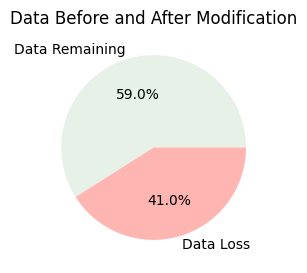

In [402]:
# <  Checking the amount of data before correction and transformation >
modified_data = df.shape[0] - df_copy.shape[0]

# Calculate the difference
data_diff = modified_data / df.shape[0] * 100

print(f"[+] Data Loss: {data_diff:.0f}%")

# Use data_before, data_after as the slices for the pie chart
plt.figure(figsize=(3, 3))
plt.pie(
    [df.shape[0], df_copy.shape[0]],
    labels=['Data Remaining', 'Data Loss'],
    autopct='%1.1f%%',
    colors=['#E7F1E8', '#FFB6B3'],
    # startangle=90
)
plt.title('Data Before and After Modification')
plt.show()

In [403]:
numerical_var.describe()

,price,registrationyear,power,mileage,registrationmonth,daysactive
count,68987.000000,68987.000000,68987.000000,68987.000000,68987.000000,68987.000000
mean,5122.921681,2002.923725,119.273950,127180.845667,6.194182,9.036949
std,4721.807565,6.145031,100.514461,37102.602396,3.479272,8.773108
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,3.000000,2.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000,6.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000,14.000000
max,20000.000000,2018.000000,11530.000000,150000.000000,12.000000,384.000000


In [404]:
categorical_var.describe()

,vehicletype,gearbox,model,fueltype,brand,notrepaired
count,68987,68987,68987,68987,68987,68987
unique,8,2,246,7,39,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,20266,54710,5637,45670,14458,61168


### 1-1-1 Observation
🔭 **Observation**:
- **Data Loss**: The amount of data loss in my opinion does not represent a problem for out task of training models predictions.
- **Scalar features**: We have variable magnitude values, which cause biases in the predictions of our model.
- **Categorical varibales**: We have different cardinality categircal variables so i'll applied `ohe-enconder` for low varibales and `target_encoder` for high varibales.

# 2-Exploratory data analysis

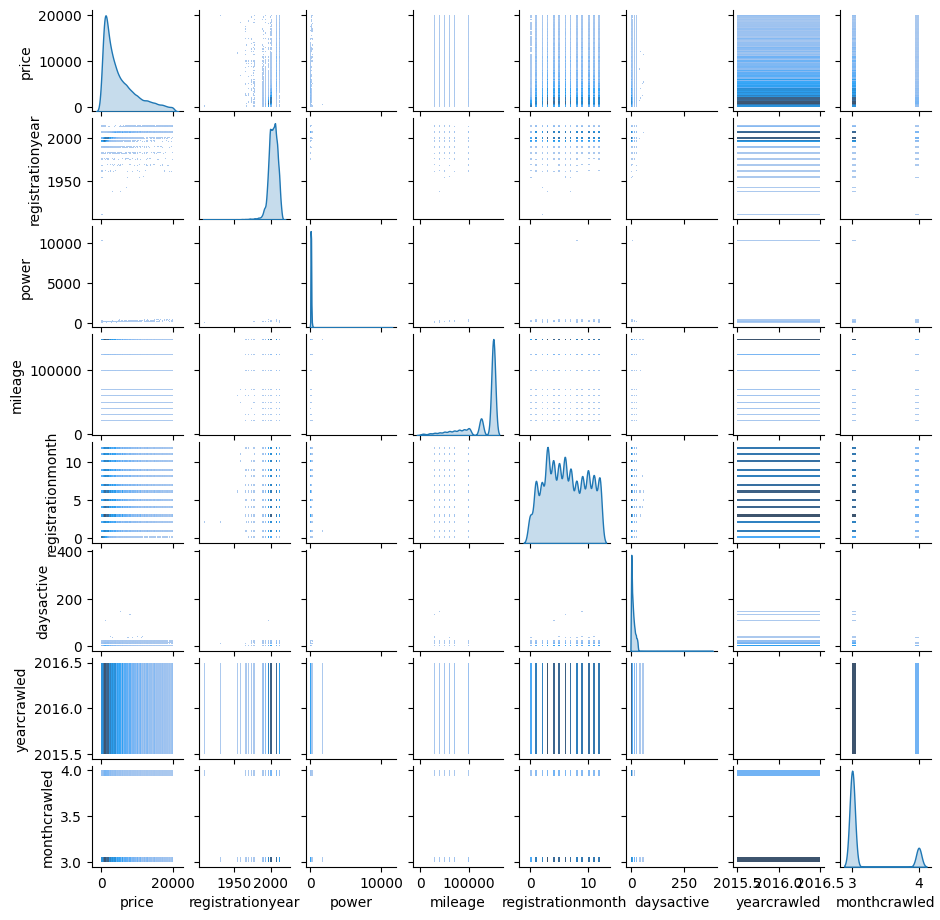

In [334]:
g = sns.pairplot(df_copy, kind='hist', diag_kind='kde')
g.fig.set_size_inches(9, 9)

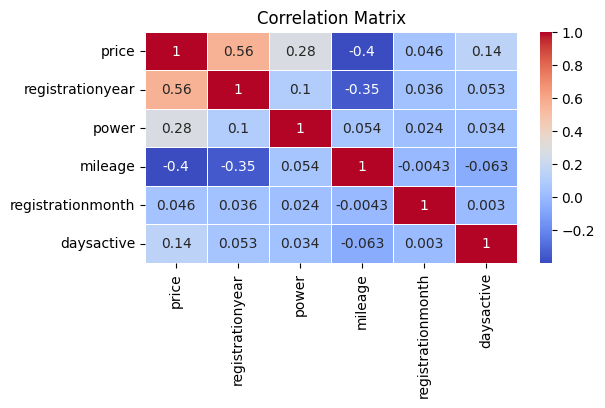

In [335]:
correlation_matrix = numerical_var.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
#

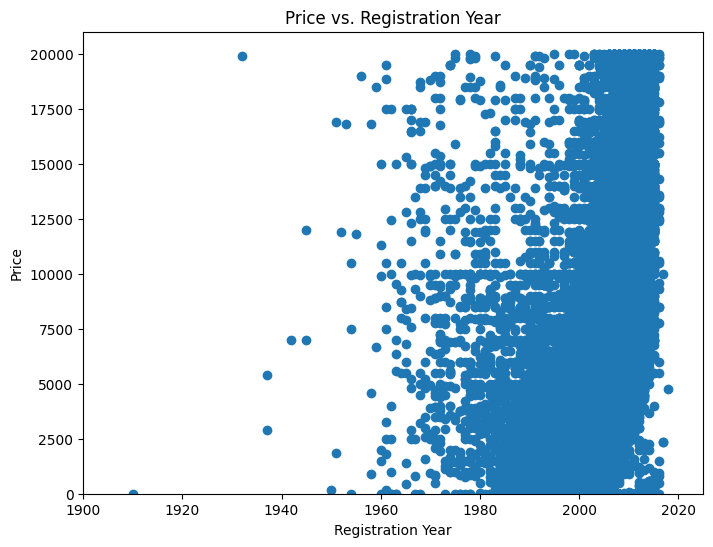

In [409]:
plt.figure(figsize=(8, 6))

plt.scatter(df_copy['registrationyear'], df_copy['price'])
plt.xlim(1900, 2025)
plt.ylim(0, 21000)
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.title('Price vs. Registration Year')
plt.show()

### 2-1-1 Observation
🔭 **Observation**:
- **Data distribution**: Looks like the our distribution does not fit the Normal distribution, so i'll make the salar with `MaxAbScaler`
- **Correlation varibles**: the varibels that have more correlation are `registrationyear` with our target `price`.
- **Scatter chart**: By looking the chart we can observate that the data doesn't fit for linear regression model

# 3- Model Creation
---

> < Create my own linear regression RandomForest class models and refine them with inheritance and GDS techniques >

# 4-Traning Models
---



In [337]:
# < Spliting categorical varibales [high & low cardinality] >
low_cardinality = ['gearbox', 'notrepaired']
high_cardinality= ['vehicletype', 'model', 'fueltype', 'brand']

In [338]:
X_features = df_copy.drop(['price'], axis=1)
y_target = df_copy['price']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

In [339]:
# < Enconding [low] cardinality varibales >
onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
X_train_ohe = onehot_encoder.fit_transform(X_train[low_cardinality])
X_test_ohe = onehot_encoder.transform(X_test[low_cardinality])

# < Encoding [hight] cardinality varibales >
cat_encoder =  ce.TargetEncoder(cols=high_cardinality)
X_train_cat = cat_encoder.fit_transform(X_train[high_cardinality], y_train)
X_test_cat = cat_encoder.transform(X_test[high_cardinality])


In [340]:
# < Scaling all the data >
scaler = sklearn.preprocessing.MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

X_train_scaled = scaler.fit_transform(X_train_cat)
X_test_scaled = scaler.transform(X_test_cat)

## 4-1-Linear, DescisionTree, RandomForest, GradientDescent Models

In [341]:

models = {
    'Linear Regression': sklearn.linear_model.LinearRegression(),
    'Decision Tree': sklearn.tree.DecisionTreeRegressor(random_state=42),
    'Random Forest': sklearn.ensemble.RandomForestRegressor(random_state=42),
    'Gradient Descent': sklearn.linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
}

results = {}
for name, model in models.items():
    # Entrenar y medir tiempo
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time

    # Predecit  y medir velocidad de entramento
    start_pred  = time.time()
    y_pred = model.predict(X_test_scaled)
    pred_time = time.time() - start_time

    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = rmse
    results[name] = {
        "RMSE": rmse,
        "Training Time (s)": train_time,
        "Prediction Time (s)": pred_time
    }

    print(f"[+] {name} RMSE: {rmse:.2f}")
    print(f"[+] {name} Training Time: {train_time:.2f} seconds")
    print(f"[+] {name} Prediction Time: {train_time:.2f} seconds")
    print()

[+] Linear Regression RMSE: 3962.23
[+] Linear Regression Training Time: 0.01 seconds
[+] Linear Regression Prediction Time: 0.01 seconds

[+] Decision Tree RMSE: 3762.42
[+] Decision Tree Training Time: 0.07 seconds
[+] Decision Tree Prediction Time: 0.07 seconds

[+] Random Forest RMSE: 3753.73
[+] Random Forest Training Time: 3.40 seconds
[+] Random Forest Prediction Time: 3.40 seconds

[+] Gradient Descent RMSE: 3962.17
[+] Gradient Descent Training Time: 0.24 seconds
[+] Gradient Descent Prediction Time: 0.24 seconds



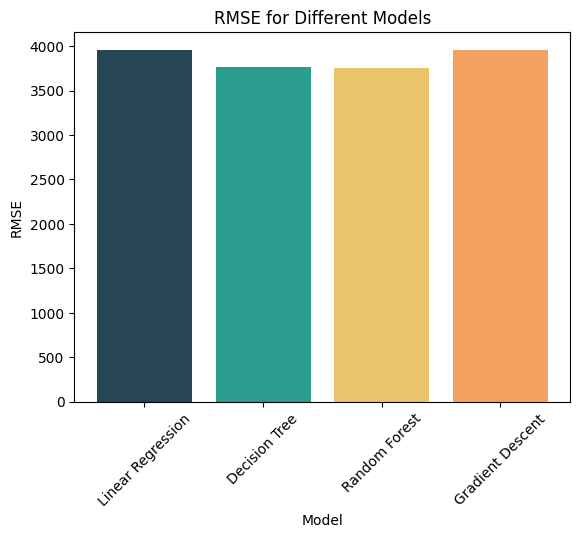

In [342]:
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

plt.bar(
    results.keys(),
    [result["RMSE"] for result in results.values()],
    color=colors
  )
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.title('RMSE for Different Models')
plt.show()


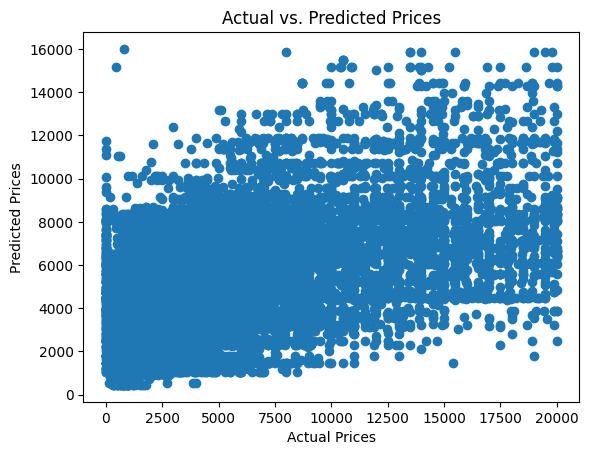

In [343]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

## 4-2-Boosting and Regularization



### 4-2-1 Linear Regression L2 Regularization

In [344]:
# < Ridge Regression (L2) >
model_ridge = sklearn.linear_model.Ridge(alpha=10.0)
model_ridge.fit(X_train_scaled, y_train)
y_pred_ridge = model_ridge.predict(X_test_scaled)

mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print(f"Ridge RMSE: {rmse_ridge:.2f}")

Ridge RMSE: 3961.71


### 4-2-2-Decision tree boosting (gradient boosting)

In [345]:
# < Gradient Boosting >
model_gb = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_gb.fit(X_train_scaled, y_train)
y_pred_gb = model_gb.predict(X_test_scaled)

mse_gb = sklearn.metrics.mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
print(f"Gradient Boosting RMSE: {rmse_gb:.2f}")

Gradient Boosting RMSE: 3871.09


### 4-2-3-Tuning Hyperparameters in Random Forest

In [346]:
# < Optimized Random Forest >
model_rf_tuned = sklearn.ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
model_rf_tuned.fit(X_train_scaled, y_train)
y_pred_rf_tuned = model_rf_tuned.predict(X_test_scaled)

mse_rf_tuned = sklearn.metrics.mean_squared_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
print(f"Random Forest Tuned RMSE: {rmse_rf_tuned:.2f}")

Random Forest Tuned RMSE: 3760.46


### 4-2-4-CatBoosting

In [363]:
# < CatBoosting Model >
from catboost import CatBoostRegressor


# < CatBoost handles categoricals natively (without One-Hot) >
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# < Training  CatBoost >
start_time = time.time()
model_catboost = CatBoostRegressor(
    iterations=1000,
    cat_features=cat_features,
    verbose=0
)
model_catboost.fit(X_train, y_train)
train_time_cat = time.time() - start_time

# Predecir
start_pred = time.time()
y_pred_cat = model_catboost.predict(X_test)
pred_time_cat = time.time() - start_pred

# Calcular RMSE
rmse_cat = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred_cat))

results["CatBoost"] = {
    "RMSE": rmse_cat,
    "Training Time (s)": train_time_cat,
    "Prediction Time (s)": pred_time_cat
}

print(f"CatBoost RMSE: {rmse_cat:.2f}")
print(f"CatBoost Training Time: {train_time_cat:.2f} seconds")
print(f"CatBoost Weather Prediction: {pred_time_cat:.2f} seconds")

CatBoost RMSE: 1630.14
CatBoost Training Time: 96.32 seconds
CatBoost Weather Prediction: 0.23 seconds


# 5-Model Analysis
---

## 5-1-RMSE Model Comparison

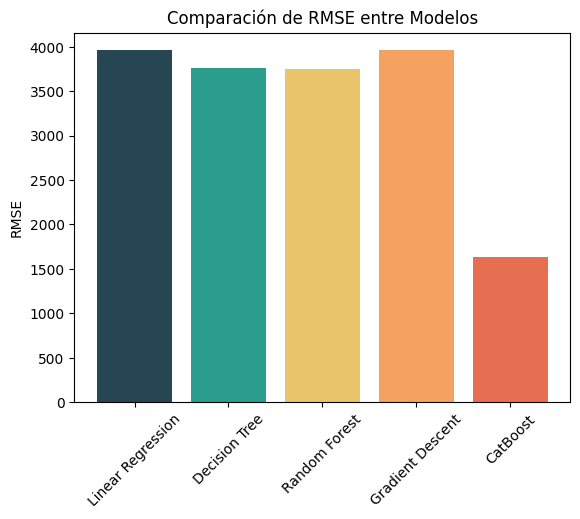

In [348]:
rmse_values = [results[model]["RMSE"] for model in results]
model_names = list(results.keys())

plt.bar(model_names, rmse_values, color=colors)
plt.title("Comparison of RMSE between Models")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

## 5-2-Prediction Time Comparison


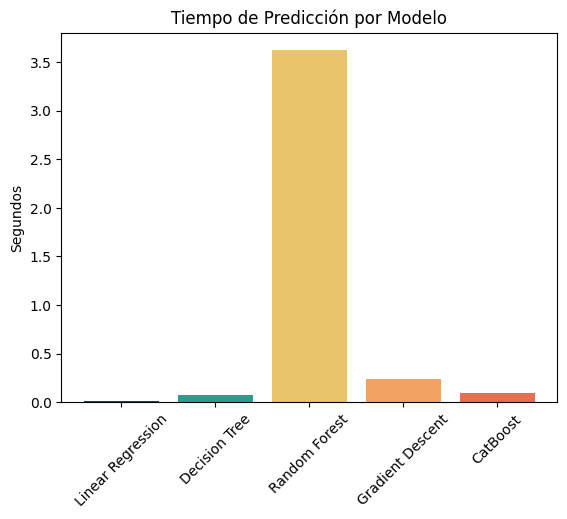

In [349]:
pred_times = [results[model]["Prediction Time (s)"] for model in results]

plt.bar(model_names, pred_times, color=colors)
plt.title("Tiempo de Predicción por Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.show()

## 5-3-Training Time Comparison

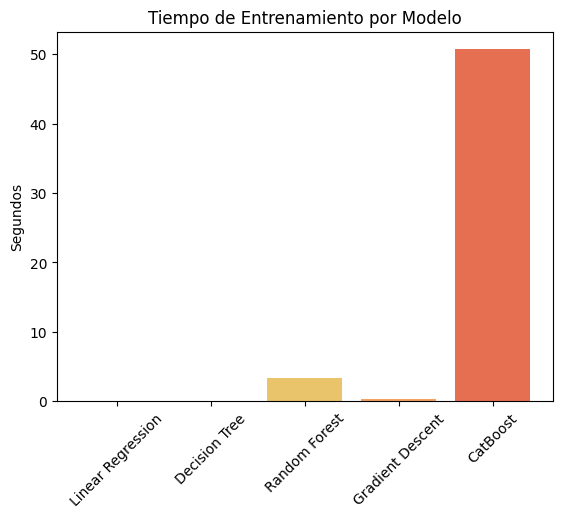

In [350]:
train_times = [results[model]["Training Time (s)"] for model in results]

plt.bar(model_names, train_times, color=colors)
plt.title("Tiempo de Entrenamiento por Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.show()

## 5-4-Result Table Comparison

In [351]:
results_df = pd.DataFrame(results).T
display(results_df.sort_values(by='RMSE'))

,RMSE,Training Time (s),Prediction Time (s)
CatBoost,1630.141350,50.723334,0.093644
Random Forest,3753.727159,3.397305,3.621143
Decision Tree,3762.420070,0.072082,0.074864
Gradient Descent,3962.173345,0.239355,0.240321
Linear Regression,3962.228646,0.010466,0.010992


### 5-5-1-Practical Test

In [352]:
# < Extracting a entry of the dataset for camparisons >
df_test = df_copy.sample(1, random_state=42)
df_test

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,daysactive,yearcrawled,monthcrawled
19335,10350,bus,2010,manual,140,touran,100000,4,petrol,volkswagen,no,27,2016,3


Precio real: $10350.00
Precio predicho: $12455.15
Error absoluto: $2105.15


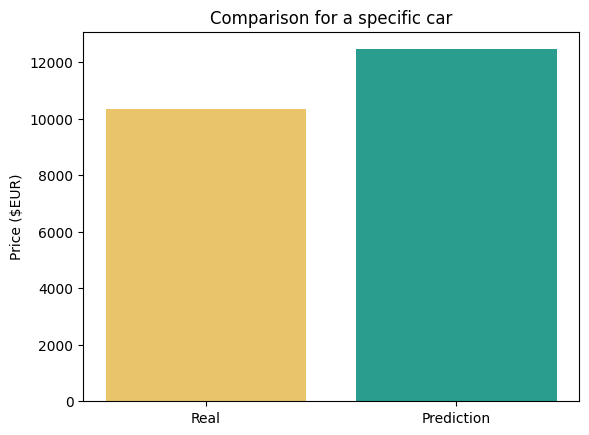

In [362]:
X = df_test.drop(['price'], axis=1)
y = df_test['price']

pred_price = model_catboost.predict(X)
real_price = y

# < # Price Comparison >
# Access the first element of the Series using .iloc[0]
print(f"Precio real: ${real_price.iloc[0]:.2f}")
print(f"Precio predicho: ${pred_price[0]:.2f}")
# Access the first element of the Series using .iloc[0] and apply abs()
print(f"Error absoluto: ${(abs(real_price.iloc[0] - pred_price[0])):.2f}")


# < # Visual individual comparison>
real_price_value = real_price.iloc[0]  # Extract the single value from the Series
pred_price_value = pred_price[0]  # Extract the single value from the array
plt.bar(["Real", "Prediction"], [real_price_value, pred_price_value], color=["#e9c46a", "#2a9d8f"])
plt.ylabel("Price ($EUR)")
plt.title("Comparison for a specific car")
plt.show()


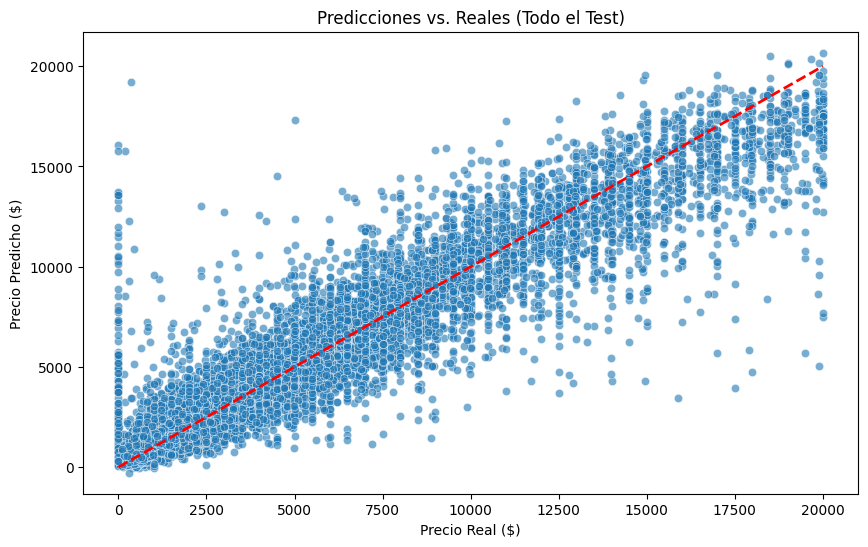

MAE en test: $1015.62
RMSE en test: $1630.14


In [354]:
# < # Vizualizaing all the predictions >
y_pred = model_catboost.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Real Price ($EUR)")
plt.ylabel("Prediction Price ($EUR)")
plt.title("Predictions vs. Real (All Test)")
plt.show()

# < # Error Metrics >
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))

print(f"MAE en test: ${mae:.2f}")
print(f"RMSE en test: ${rmse:.2f}")

# 6-Conclusions